In [1]:
from numpy import array
import numpy as np
import pandas as pd
import pylab as pl
import scipy as sp
import scipy.stats as sps
import math
import time
import matplotlib as mp
import matplotlib.pyplot as plt
import datetime as dt

## 1. Down-and-In Put option

### Down-and-In Put option (Geometric Brownian motion dynamics)

In [9]:
S0=50
r=0.10
K=50
T=5/12
NSamples=100 #number of steps
NRepl=1000 #number of paths generated

In [10]:
def AssetPaths(S0,mu,sigma,T,NSamples,NRepl): 
    SPaths =0.0* np.zeros((NRepl,NSamples));
    SPaths[:,0] = S0;
    dt = T/NSamples;
    nudt = (mu-0.5*sigma**2)*dt;
    sidt = sigma*np.sqrt(dt) ;
    for i in range(0,NRepl):
        for j in range(0,NSamples-1):
            SPaths[i,j+1] = SPaths[i,j]*np.exp(nudt+sidt*np.random.normal(0,1,1));
    return SPaths

def DownInPut(S0,K,r,T,sigma,Sb):
    payoff=np.zeros(NRepl)
    for i in range(0,NRepl):
        GBM=AssetPaths(S0,r,sigma,T,NSamples,1)
        if GBM[0,-1] < Sb:
            payoff[i] = np.maximum(0,K-GBM[0,-1])
        else:
            payoff[i] = 0
    p=np.mean(np.exp(-r*T)*payoff)
    return p

In [12]:
Sb=40
sigma=0.4
print('Down-and-In Put premium for K='+str(K)+' and barrier='+str(Sb))
print(round(DownInPut(S0,K,r,T,sigma,Sb),3))

Down-and-In Put premium for K=50 and barrier=40
2.557


#### Option premium depicted for different barrier levels and volatility

In [13]:
Sb=np.linspace(1,49,100)
sigma=np.array([0.3,0.35,0.4])

In [14]:
premiums_03 = []
for Sb in np.linspace(1, 49, 100):
    price = DownInPut(S0,K,r,T,0.3,Sb)
    premiums_03.append(price)

premiums_035 = []
for Sb in np.linspace(1, 49, 100):
    price = DownInPut(S0,K,r,T,0.35,Sb)
    premiums_035.append(price)

premiums_04 = []
for Sb in np.linspace(1, 49, 100):
    price = DownInPut(S0,K,r,T,0.4,Sb)
    premiums_04.append(price)

df_2 = pd.DataFrame(np.linspace(1, 49, 100), columns = ["Barrier Level"])
df_2["σ = 0.30"] = premiums_03
df_2["σ = 0.35"] = premiums_035
df_2["σ = 0.40"] = premiums_04

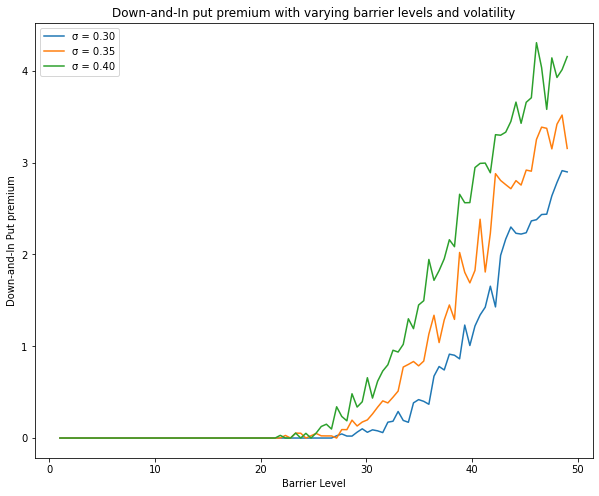

In [15]:
plt.figure(figsize = (10,8))
ax = plt.gca()
df_2.plot(kind='line', x="Barrier Level", y="σ = 0.30", ax=ax)
df_2.plot(kind='line', x="Barrier Level", y="σ = 0.35", ax=ax)
df_2.plot(kind='line', x="Barrier Level", y="σ = 0.40", ax=ax)
plt.ylabel('Down-and-In Put premium')
plt.xlabel('Barrier Level') 
plt.title('Down-and-In put premium with varying barrier levels and volatility')
plt.show()

### Down-and-in Put option (Heston Stochastic volatility dynamics)

In [17]:
S0 = 50 #current stock price
K= 50 # strike price
T = 5/12 # time to maturity, equivalent to 5 months
r = 0.10 # risk-free interest rate
kappa = 2 # mean reversion parameter
vbar = 0.35**2 # long term variance
v0 = 0.35**2 # current variance
rho = 0 # correlation coefficient
eta = 0.25 # volatility of variance parameter
NSteps = 100
dt = T/NSteps

In [18]:
param=[kappa,vbar,eta,rho]

In [ ]:
def Heston_paths(S0,v0,r,param,NSteps,dt):
    kappa = param[0];
    vbar  = param[1];
    eta   = param[2];
    rho   = param[3];   
    
    W    = np.random.multivariate_normal(np.array([0, 0]), np.matrix([[1, rho], [rho, 1]]), NSteps)*np.sqrt(dt) 
    W_S  = W[:,0]
    W_v  = W[:,1]
    St    = np.zeros(NSteps)
    vt    = np.zeros(NSteps)
    
    # Generate paths
    St[0] = S0    
    vt[0] = vbar
    for t in range(1,NSteps):
        vt[t] = np.abs(vt[t-1] + kappa*(vbar-vt[t-1])*dt + eta*np.sqrt(vt[t-1])*W_v[t])
        St[t] = St[t-1]*np.exp(r*dt + np.sqrt(vt[t])*W_S[t])
    return St, vt

#### Down-and-In Put option by MonteCarlo Simulations

In [ ]:
def DownInPutMC(S0,K,r,dt,param,Sb,NSteps,NRepl):
    payoff = np.zeros(NRepl)
    for i in range(0,NRepl):
        path = Heston_paths(S0,v0,r,param,NSteps,dt)
        if path[0,-1].any() < Sb:
            payoff[i] = np.maximum(0,K-path[0,-1])
        else:
            payoff[i] = 0
    p,se = np.mean(np.exp(-r*dt)*payoff),sp.stats.sem(np.exp(-r*dt)*payoff)   
    return p,se

In [21]:
Sb=30
NSteps=500
NRepl=1000
price,se = DownInPutMC(S0,K,r,dt,param, Sb,NSteps, NRepl)
print('The price of a Down-and-in Put option for K='+str(K)+'and barrier='+str(Sb)+' is : '+str(price))
print('The standard error is : '+str(se))

The price of a Down-and-in Put option for K=50and barrier=30 is : 0.02789716013104757
The standard error is : 0.006976664476733152


#### Confidence Intervals on the option premium

In [22]:
#Confidence intervals at 95% using the quantile of the normal distribution
ta=sps.norm.ppf(0.975)

lower_bound = round(price-ta*se,3)
upper_bound = round(price+ta*se,3)
print(f"The 95% confidence interval is: [{lower_bound, upper_bound}]")

The 95% confidence interval is: [(0.014, 0.042)]


In [23]:
#Confidence intervals at 90% using the quantile of the normal distribution
ta=sps.norm.ppf(0.95)

lower_bound = round(price-ta*se,3)
upper_bound = round(price+ta*se,3)
print(f"The 90% confidence interval is: [{lower_bound, upper_bound}]")

The 90% confidence interval is: [(0.016, 0.039)]


## 2. Asian Call option

#### Computed Asian Geometric Average Call option 

In [24]:
def GeomAsianCall(S0,K,r,T,sigma,NSteps):
    v = r-0.5*sigma**2
    dt = T/NSteps
    a = np.log(S0)+v*dt+(1/2)*v*(T-dt)
    b = sigma**2*dt+((sigma**2*(T-dt))/(6*NSteps))*(2*NSteps-1)
    x = (a-np.log(K)+b)/(np.sqrt(b))
    p = np.exp(-r*T)*(np.exp(a+(1/2)*b)*sp.stats.norm.cdf(x)-K*sp.stats.norm.cdf(x-np.sqrt(b)))
    return p

In [25]:
print(f"Price of the Asian Geometric Average rate Call option: {round(GeomAsianCall(50,55,0.05,1/12,0.4,12),3)}")

Price of the Asian Geometric Average rate Call option: 0.158


#### Computed Asian Arithmetic Average Call option using Monte Carlo simulation

In [26]:
def AssetPaths(S0,r,sigma,T,NSteps,NRepl): 
    SPaths =0.0* np.zeros((NRepl,NSteps));
    SPaths[:,0] = S0;
    dt = T/NSteps;
    nudt = (r-0.5*sigma**2)*dt;
    sidt = sigma*np.sqrt(dt) ;
    for i in range(0,NRepl):
        for j in range(0,NSteps-1):
            SPaths[i,j+1] = SPaths[i,j]*np.exp(nudt+sidt*np.random.normal(0,1,1));
    return SPaths

In [27]:
def AsianMC(S0,K,r,T,sigma,NSteps,NRepl):
    #Monte Carlo simulation for an Asian option
    payoff = np.zeros(NRepl);
    for i in range(0,NRepl):
        path = AssetPaths(S0,r,sigma,T,NSteps,1);
        payoff[i] = np.maximum(0,np.mean(path[0,:])-K); #arithmetic average
    p,se = np.mean(np.exp(-r*T)*payoff),sp.stats.sem(np.exp(-r*T)*payoff);   
    return p,se

In [28]:
print("Asian arithmetic average rate Call option by Monte Carlo simulation")
print(f"Price: {round(AsianMC(50,55,0.05,1/12,0.4,12,10000)[0],3)}")
print(f"Standard Error: {round(AsianMC(50,55,0.05,1/12,0.4,12,10000)[1],3)}")

Asian arithmetic average rate Call option by Monte Carlo simulation
Price: 0.109
Standard Error: 0.005


### Control Variate Method

In [29]:
S0=50
T = 1/12 # maturity
K = 55 # strike
NSteps = 12 # sample paths with n time steps
NRepl = 9000 # number of replications
NPilot = 1000 # number of pilot replications
sigma = 0.4
r = 0.05

#### Geometric Average Call option as Control Variate Method

In [30]:
def GeomAsianCallMCCV(S0,K,r,T,sigma,NSteps,NRepl,NPilot):
    #pilot replications to set control parameter
    samplePath = AssetPaths(S0,r,sigma,T,NSteps,NPilot);
    arimean = np.mean(samplePath[:,0:(NSteps)],1)
    geomean = np.prod(samplePath,1)**(1/NSteps)
    Arith_p=np.exp(-r*T)*np.maximum(0,arimean-K) #VA_hat
    Geom_p=np.exp(-r*T)*np.maximum(0,geomean-K) #VB_hat
    
    MatCov = np.cov(Arith_p,Geom_p); # check covariance between the 2 estimated option values
    c = -MatCov[0,1]/np.var(Geom_p); # value which minimizes the variance of VA_hat
    dt = T/NSteps;  
    VB = GeomAsianCall(S0,K,r,T,sigma,NSteps); #VB is ExpSum (true value of option B)
    
    #Monte Carlo simulation for an Asian option
    ControlVars = np.zeros(NRepl);
    for i in range(0,NRepl):
        Path = AssetPaths(S0,r,sigma,T,NSteps,1);
        Arith_p=np.exp(-r*T)*np.maximum(0,np.mean(Path[0,0:(NSteps)])-K)
        Geom_p=np.exp(-r*T)*np.maximum((np.prod(Path[0,:])**(1/NSteps))-K,0)
        ControlVars[i] = Arith_p+c*(Geom_p-VB); 
        
    p,se = np.mean(ControlVars),sp.stats.sem(ControlVars);
    return p,se

In [31]:
print("With the geometric average rate call option as a control variate")
print(f"Price: {round(GeomAsianCallMCCV(S0,K,r,T,sigma,NSteps,NRepl,NPilot)[0],3)}")
print(f"Standard Error: {round(GeomAsianCallMCCV(S0,K,r,T,sigma,NSteps,NRepl,NPilot)[1],5)}")

With the geometric average rate call option as a control variate
Price: 0.104
Standard Error: 0.00479


#### Arithmetic Average Call option as Control Variate Method

In [32]:
def AverAsianCallMCCV(S0,K,r,T,sigma,NSteps,NRepl,NPilot):
    #pilot replications to set control parameter
    samplePath = AssetPaths(S0,r,sigma,T,NSteps,NPilot);
    sampleST=np.sum(samplePath,1)/NSteps
    ST=np.mean(samplePath,1)
    TryPayoff=np.exp(-r*T)*np.maximum(0,ST-K)
    
    MatCov = np.cov(SampleST,TryPayoff)
    c = -MatCov[0,1]/np.var(sampleST)
    dt = T/NSteps;
    ExpSum = S0*(1-np.exp((NSteps+1)*r*dt))/(1-np.exp(r*dt))/NSteps
    
    #Monte Carlo simulation with control variates for an Asian option.
    ControlVars = np.zeros(NRepl); 
    for i in range(0,NRepl):
        StockPath = AssetPaths(S0,r,sigma,T,NSteps,1);
        Payoff = np.exp(-r*T)*max(0,np.mean(StockPath)-K); # discounted cash flows of the derivative for each path 
        ControlVars[i] = Payoff+c*(sum(StockPath[0,])/NSteps-ExpSum); # control variate estimate
        
    p,se = np.mean(ControlVars),sp.stats.sem(ControlVars);
    return p,se

In [33]:
print("With the average mean of the asset prices as a control variate")
print(f"Price: {round(AverAsianCallMCCV(S0,K,r,T,sigma,NSteps,NRepl,NPilot)[0],3)}")
print(f"Standard Error: {round(AverAsianCallMCCV(S0,K,r,T,sigma,NSteps,NRepl,NPilot)[1],3)}")

With the average mean of the asset prices as a control variate
Price: 0.509
Standard Error: 0.005
